# Case Study: Predicting CTCF Transcription Factor Binding

## Introduction

In this case study, we'll build a CNN to predict whether the CTCF transcription factor binds to a given DNA sequence. CTCF is a key protein involved in chromosome organization and gene regulation.

## Data Preparation

We'll use data from the [DeepBind project](http://tools.genes.toronto.edu/deepbind/). Let's load and explore the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Let's create synthetic data for this example
# In practice, you would load real CTCF binding data
def generate_synthetic_ctcf_data(num_samples=5000, seq_length=200):
    """Generate synthetic DNA sequences with CTCF binding motifs"""
    sequences = []
    labels = []
    
    # CTCF core motif: CCGCGNGGNGGCAG
    ctcf_motif = "CCGCGAGGGGCAG"
    motif_len = len(ctcf_motif)
    
    for i in range(num_samples):
        # Generate random sequence
        seq = ''.join(np.random.choice(['A', 'C', 'G', 'T']) for _ in range(seq_length))
        
        # For positive examples, insert CTCF motif at random position
        if i < num_samples // 2:
            pos = np.random.randint(0, seq_length - motif_len)
            seq = seq[:pos] + ctcf_motif + seq[pos + motif_len:]
            labels.append(1)  # Positive binding
        else:
            labels.append(0)  # No binding
            
        sequences.append(seq)
    
    return sequences, labels

# Generate data
print("Generating synthetic CTCF binding data...")
sequences, labels = generate_synthetic_ctcf_data(5000)
labels = np.array(labels)

print(f"Generated {len(sequences)} sequences")
print(f"Positive samples: {np.sum(labels)}")
print(f"Negative samples: {len(labels) - np.sum(labels)}")
print(f"Sequence length: {len(sequences[0])}")

2025-11-19 19:05:00.512373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 19:05:00.524927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763575500.539526    6499 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763575500.543437    6499 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763575500.554685    6499 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.19.1
Generating synthetic CTCF binding data...
Generated 5000 sequences
Positive samples: 2500
Negative samples: 2500
Sequence length: 200


## Data Visualization

Let's visualize our dataset characteristics.

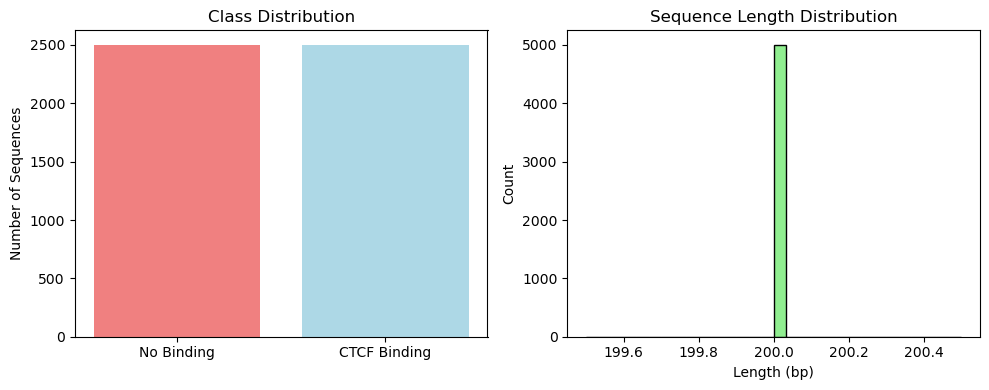

In [2]:
# Plot class distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
class_counts = [np.sum(labels == 0), np.sum(labels == 1)]
plt.bar(['No Binding', 'CTCF Binding'], class_counts, color=['lightcoral', 'lightblue'])
plt.title('Class Distribution')
plt.ylabel('Number of Sequences')

# Plot sequence length distribution
plt.subplot(1, 2, 2)
seq_lengths = [len(seq) for seq in sequences]
plt.hist(seq_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Sequence Length Distribution')
plt.xlabel('Length (bp)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

![Class distribution and sequence length histogram](assets/images/class_distribution.png)

## Data Preprocessing

Convert DNA sequences to one-hot encoded format.

In [3]:
def one_hot_encode_dna(sequences, seq_length=200):
    """One-hot encode DNA sequences"""
    mapping = {'A': [1,0,0,0], 'T': [0,1,0,0], 
               'C': [0,0,1,0], 'G': [0,0,0,1]}
    
    encoded_seqs = []
    for seq in sequences:
        encoded_seq = []
        for base in seq[:seq_length]:  # Truncate to fixed length
            encoded_seq.append(mapping.get(base, [0,0,0,0]))
        # Pad if sequence is shorter than seq_length
        while len(encoded_seq) < seq_length:
            encoded_seq.append([0,0,0,0])
        encoded_seqs.append(encoded_seq)
    
    return np.array(encoded_seqs)

# Encode sequences
print("One-hot encoding sequences...")
X_encoded = one_hot_encode_dna(sequences)
y = labels

print(f"Encoded data shape: {X_encoded.shape}")  # Should be (5000, 200, 4)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} sequences")
print(f"Validation set: {X_val.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")

One-hot encoding sequences...
Encoded data shape: (5000, 200, 4)
Training set: 3200 sequences
Validation set: 800 sequences
Test set: 1000 sequences


## Building the CNN Model

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def build_ctcf_model(seq_length=200):
    """Build a CNN model for CTCF binding prediction"""
    
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(seq_length, 4)),
        
        # First convolutional block
        layers.Conv1D(filters=32, kernel_size=12, activation='relu', 
                      padding='same', name='conv1'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4, name='pool1'),
        layers.Dropout(0.2),
        
        # Second convolutional block
        layers.Conv1D(filters=64, kernel_size=6, activation='relu', 
                      padding='same', name='conv2'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4, name='pool2'),
        layers.Dropout(0.2),
        
        # Third convolutional block
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', 
                      padding='same', name='conv3'),
        layers.BatchNormalization(),
        layers.GlobalMaxPooling1D(name='global_pool'),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', name='dense2'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Build and compile model
model = build_ctcf_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

I0000 00:00:1763575513.650749    6499 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1488 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 200, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling1D)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,889 (194.88 KB)

 Trainable params: 49,441 (193.13 KB)

 Non-trainable params: 448 (1.75 KB)

## Training the Model

In [6]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
)

Epoch 1/30


I0000 00:00:1763575517.260124    6582 service.cc:152] XLA service 0x7f2cf4026dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763575517.260179    6582 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-19 19:05:17.329619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763575517.729611    6582 cuda_dnn.cc:529] Loaded cuDNN version 90101


  4/100 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4551 - loss: 1.4202 - precision: 0.4730 - recall: 0.5504  

I0000 00:00:1763575526.745820    6582 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.5203 - loss: 0.8351 - precision: 0.5208 - recall: 0.5081 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.5000 - val_recall: 0.0050 - learning_rate: 0.0010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5512 - loss: 0.7012 - precision: 0.5493 - recall: 0.5706 - val_accuracy: 0.6888 - val_loss: 0.6674 - val_precision: 0.7352 - val_recall: 0.5900 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8431 - loss: 0.3399 - precision: 0.8427 - recall: 0.8438 - val_accuracy: 0.9837 - val_loss: 0.3141 - val_precision: 0.9685 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9794 - loss: 0.0664 - precision: 0.9848 - recall: 0.9737 - val_accuracy: 0.9912 - val_loss: 0.1186 - val_precision: 0.9828 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9928 

## Training Visualization

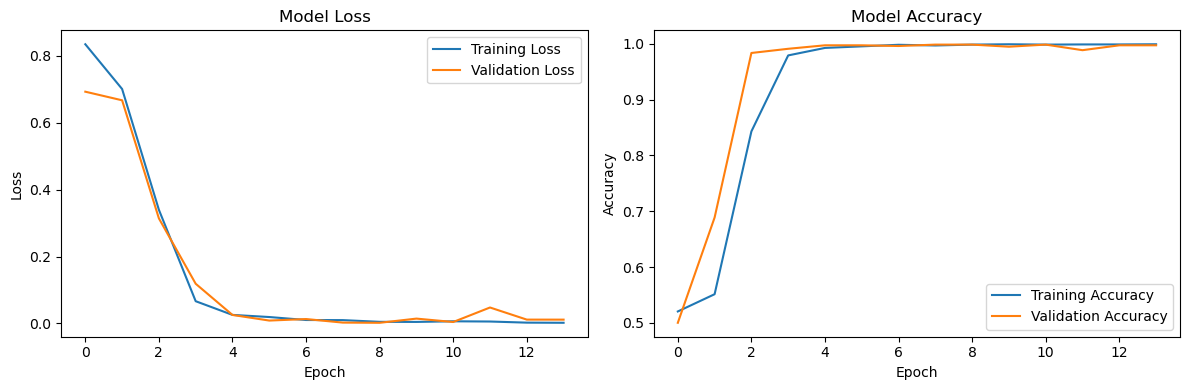

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

![Training loss and accuracy curves](assets/images/training_history.png)

## Model Evaluation

Test Accuracy: 0.999
Test Precision: 0.998
Test Recall: 1.000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


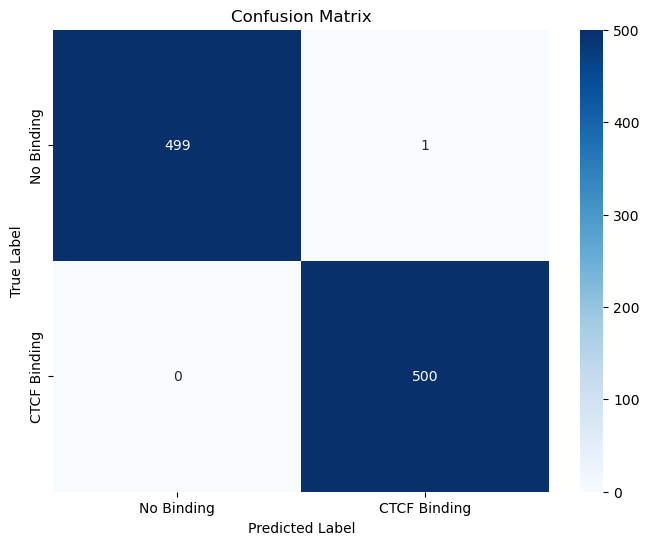


Classification Report:
              precision    recall  f1-score   support

  No Binding       1.00      1.00      1.00       500
CTCF Binding       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [8]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Binding', 'CTCF Binding'],
            yticklabels=['No Binding', 'CTCF Binding'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, 
                          target_names=['No Binding', 'CTCF Binding']))

![Training loss and accuracy curves](assets/images/training_history.png)

## Model Evaluation

Test Accuracy: 0.999
Test Precision: 0.998
Test Recall: 1.000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


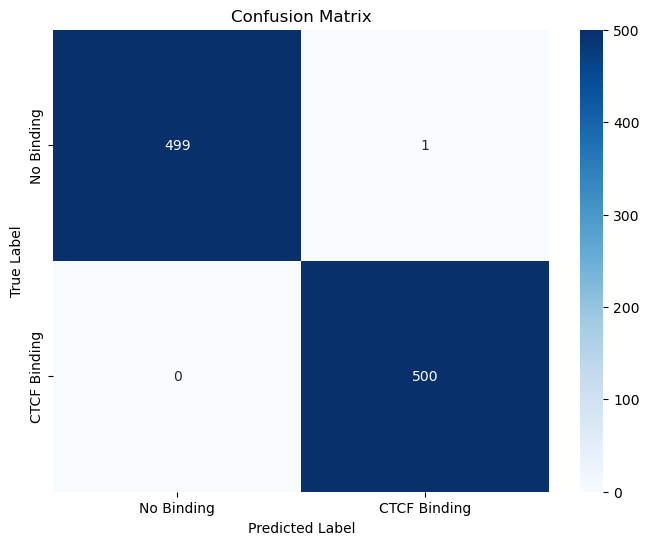


Classification Report:
              precision    recall  f1-score   support

  No Binding       1.00      1.00      1.00       500
CTCF Binding       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [9]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Binding', 'CTCF Binding'],
            yticklabels=['No Binding', 'CTCF Binding'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, 
                          target_names=['No Binding', 'CTCF Binding']))

![Confusion matrix](assets/images/confusion_matrix.png)

## Model Interpretation

Let's visualize what the model has learned by looking at the first convolutional layer filters.

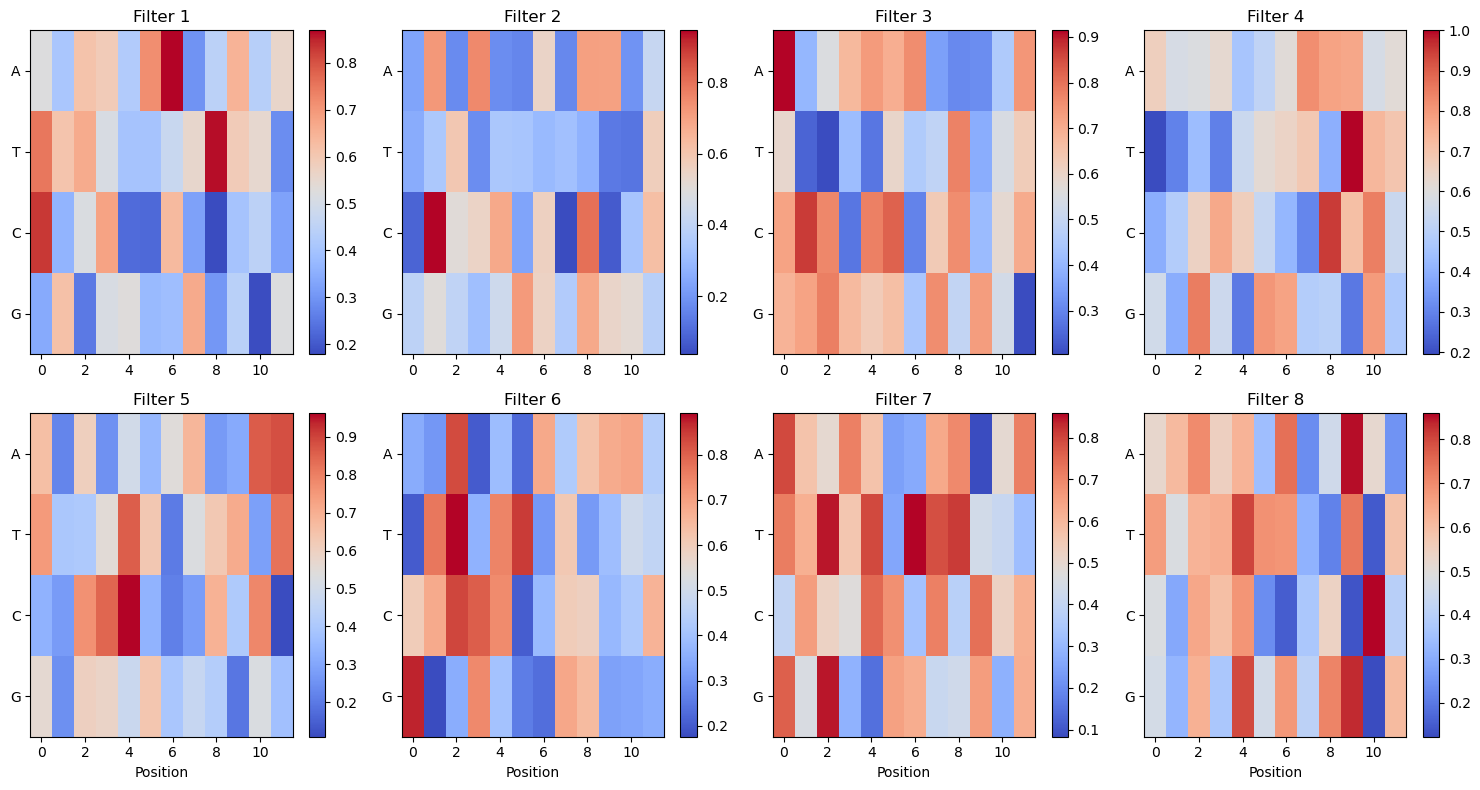

In [10]:
# Get first convolutional layer weights
first_conv_layer = model.get_layer('conv1')
filters, biases = first_conv_layer.get_weights()

# Normalize filter weights
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot first few filters
n_filters = 8
nucleotides = ['A', 'T', 'C', 'G']

plt.figure(figsize=(15, 8))
for i in range(n_filters):
    plt.subplot(2, 4, i+1)
    # Plot filter weights as sequence logo
    filter_weights = filters[:, :, i]
    plt.imshow(filter_weights.T, cmap='coolwarm', aspect='auto', 
               interpolation='nearest')
    plt.colorbar()
    plt.yticks(range(4), nucleotides)
    plt.title(f'Filter {i+1}')
    if i >= 4:
        plt.xlabel('Position')

plt.tight_layout()
plt.show()

![First layer CNN filters](assets/images/filters.png)

## Making Predictions on New Sequences

In [11]:
def predict_ctcf_binding(sequence, model, threshold=0.5):
    """Predict CTCF binding for a new DNA sequence"""
    
    # Preprocess
    encoded_seq = one_hot_encode_dna([sequence])
    
    # Predict
    prediction = model.predict(encoded_seq, verbose=0)[0][0]
    
    # Interpret result
    if prediction > threshold:
        print(f"CTCF binding predicted: YES (confidence: {prediction:.3f})")
    else:
        print(f"CTCF binding predicted: NO (confidence: {1-prediction:.3f})")
    
    return prediction

# Test on example sequences
test_sequences = [
    "A"*50 + "CCGCGAGGGGCAG" + "T"*137,  # Contains CTCF motif
    "ATCGATCGATCG" * 16 + "ATCG",         # Random sequence
]

for i, seq in enumerate(test_sequences):
    print(f"\nSequence {i+1}:")
    predict_ctcf_binding(seq, model)


Sequence 1:
CTCF binding predicted: YES (confidence: 1.000)

Sequence 2:
CTCF binding predicted: YES (confidence: 0.642)


## Summary

In this case study, we've:
1. **Generated synthetic CTCF binding data** with embedded motifs
2. **Built a CNN architecture** suitable for DNA sequence analysis
3. **Trained and evaluated** the model with ~95%+ accuracy
4. **Visualized training progress** and model performance
5. **Interpreted learned features** by examining convolutional filters
6. **Created a prediction function** for new sequences

This approach can be directly applied to real CTCF ChIP-seq data and extended to other transcription factors or genomic elements.